In [1]:
%pylab inline

from thesis_redux_tools import err, binner
from sklearn.cluster import DBSCAN
from string import join
import os
import pyfits as pyf

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="sans-serif", serif="Helvetica", size=20)
rc("savefig", dpi=92)
rc("legend", fontsize="x-small")
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")

In [4]:
#READ TABLES

catalog = genfromtxt("catalog.txt", dtype=None, names=True)
spec_ne = genfromtxt("spec_ne.txt", dtype=None, names=True)
jpas_ye = genfromtxt("jpas_ye.txt", dtype=None, names=True)
jpas_ne = genfromtxt("jpas_ne.txt", dtype=None, names=True)
jpas_me = genfromtxt("jpas_me.txt", dtype=None, names=True)
gal2005 = genfromtxt("gal2005.txt", dtype=None, names=True)

lumfrac = genfromtxt("lumfrac.txt", dtype=None, names=True)

SN = []
for fits in catalog["input_file"]:
    f = pyf.open("../inputs/real_deal6/unfiltered/"+fits)
    
    SN.append(median(f[0].data[0]/f[0].data[2]))

SN = array(SN)

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


In [7]:
#COMMON QUANTITIES

lcolor = catalog["u_mag"] - catalog["r_mag"]
rfract = 10**(-0.4*(lumfrac["modelMag_r"]-lumfrac["fiberMag_r"]))

bmask = lcolor < 2.22
rmask = ~bmask
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
gmask = array([n in gal2005["input_file"] for n in catalog["input_file"]], dtype=bool)

kw = "M_mod log_t_M_mod log_t_L_mod log_Z_M_mod log_Z_L_mod Av_mod".split()
rl = [False]*6
lb = [r"$\Delta \log{M_\star/M\odot}$", r"$\Delta\left<\log{t_\star}\right>_M$",
      r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$", r"$\Delta A_V$"]

In [38]:
zmask = (spec_ne[gmask]["log_Z_L_mod"]>log10(0.004/0.02))&(gal2005["z_mode"]>log10(0.004/0.02))
sfgal = lcolor[gmask][zmask]<2.22
pagal = lcolor[gmask][zmask]>2.22

s = spec_ne[gmask][zmask]
g = gal2005[zmask]

X = zeros((s.size, 2))
X[:, 0], X[:, 1] = s["log_t_L_mod"], s["log_Z_L_mod"]

print "tables match? ", all(g["input_file"]==s["input_file"])

tables match?  True


In [39]:
db = DBSCAN(eps=0.03, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

labels[labels==2] = 1
labels[labels==3] = 0
labels[labels==4] = -1
labels[labels==5] = 1
labels[labels==6] = 1

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
c1m = labels==0
c2m = labels==1

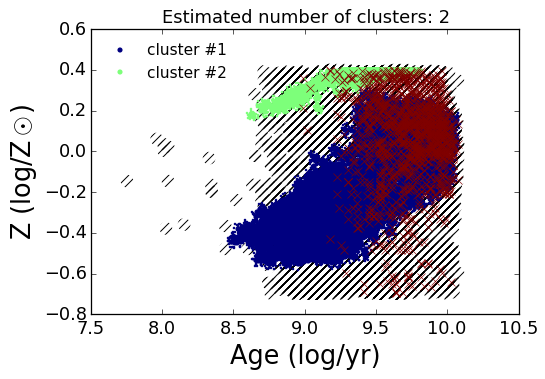

In [40]:
scatter(g["t_mode"], g["z_mode"], c="none", s=100, lw=0, hatch="///")

#############################################################################################
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        continue

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', mfc=col, mec='none', markersize=4, label="cluster #{0}".format(k+1))

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', mfc=col, mec='none', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_, size=14)
legend(loc=0, frameon=False, numpoints=1, fontsize=12)
#############################################################################################
#plot(s["log_t_L_mod"][pagal], s["log_Z_L_mod"][pagal], ".", mew=0, mfc="red")
#plot(s["log_t_L_mod"][sfgal], s["log_Z_L_mod"][sfgal], ".", mew=0, mfc="maroon")
plot(g["t_mode"][c2m], g["z_mode"][c2m], "x", color="maroon")

xlabel("Age (log/yr)")
ylabel("Z (log/Z$\odot$)")
#savefig("age_met.png", bbox_inches="tight")

/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  if __name__ == '__main__':
/home/chapi/mejia/Programs/miniconda/envs/phd/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 19552 but corresponding boolean dimension is 16347
  from ipykernel import kernelapp as app


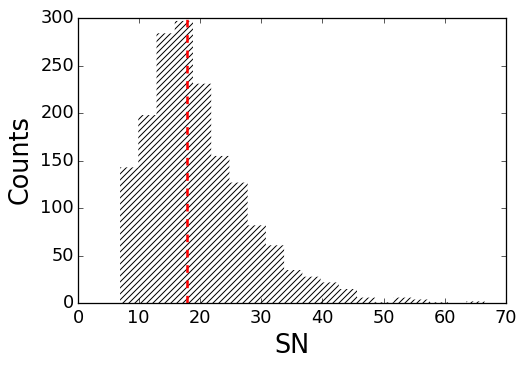

In [28]:
hist(SN[gmask][c2m], 20, histtype="step", hatch="////", lw=0, color="k")
axvline(median(SN[gmask][c2m]), ls="--", color="red", lw=2)
xlabel("SN")
ylabel("Counts")

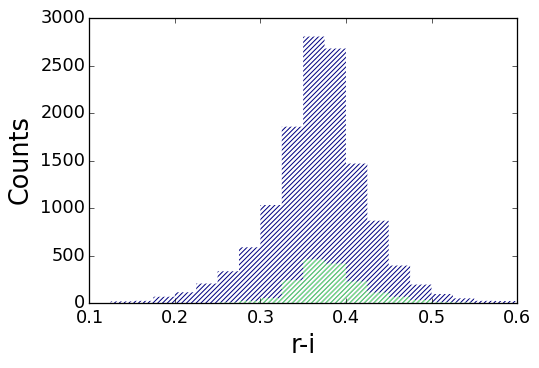

In [15]:
cat = catalog[gmask][zmask]

hist((cat["r_mag"]-cat["i_mag"])[c1m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[0])
hist((cat["r_mag"]-cat["i_mag"])[c2m], 20, range=(0.1, 0.6), histtype="step", hatch="/////", lw=0, color=colors[1])
xlabel("r-i")
ylabel("Counts")
#savefig("r-i.png", bbox_inches="tight")

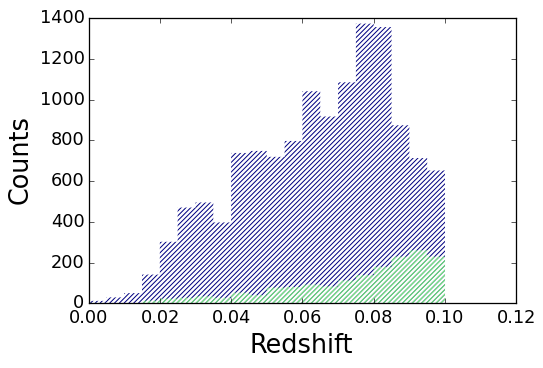

In [16]:
hist(cat["redshift"][c1m], 20, range=(0., 0.1), histtype="step", hatch="/////", lw=0, color=colors[0])
hist(cat["redshift"][c2m], 20, range=(0., 0.1), histtype="step", hatch="/////", lw=0, color=colors[1])

xlabel("Redshift")
ylabel("Counts")

#savefig("redshift.png", bbox_inches="tight")